In [1]:
import tigramite
from tigramite import data_processing as pp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
import numpy as np
import networkx as nx
import pandas as pd
import os

/Users/tangruijie/anaconda3/envs/l/lib/python3.12/site-packages/tigramite-5.2.5.11-py3.12.egg/tigramite/pcmci.py:1759: SyntaxWarning: invalid escape sequence '\m'
/Users/tangruijie/anaconda3/envs/l/lib/python3.12/site-packages/tigramite-5.2.5.11-py3.12.egg/tigramite/pcmci.py:1965: SyntaxWarning: invalid escape sequence '\w'
/Users/tangruijie/anaconda3/envs/l/lib/python3.12/site-packages/tigramite-5.2.5.11-py3.12.egg/tigramite/pcmci.py:1759: SyntaxWarning: invalid escape sequence '\m'
/Users/tangruijie/anaconda3/envs/l/lib/python3.12/site-packages/tigramite-5.2.5.11-py3.12.egg/tigramite/pcmci.py:1965: SyntaxWarning: invalid escape sequence '\w'


In [2]:
pc_alpha = 0.001
data = np.genfromtxt('data/Cleaned_SP500_Data_latest_return.csv', delimiter=',', skip_header=1)
data_tigramite = pp.DataFrame(data)
pcmci = PCMCI(dataframe=data_tigramite,
        cond_ind_test=ParCorr())
results = pcmci.run_pcmci(tau_max=3, pc_alpha=pc_alpha)

In [3]:
res_dict = pcmci.all_parents
# print(res_dict)

In [4]:
nodes = [i for i in range(data.shape[1])]
G = nx.DiGraph()
G.add_nodes_from(nodes)
for effect in res_dict:
    for cause, _ in res_dict[effect]:
        G.add_edges_from([(cause, effect)])
# print(G.edges)

In [5]:
output_directory = "./causal_graphs"
os.makedirs(output_directory, exist_ok=True)
output_filename = os.path.join(output_directory, f'latest_sp500_return_graph_pcmci_{pc_alpha}_lag_3.txt')
nx.write_adjlist(G, output_filename)

In [6]:
tickers = pd.read_csv('data/Cleaned_SP500_Data_latest_return.csv', delimiter=',', nrows=1).columns.to_list()
mapping = {i: tickers[i] for i in G.nodes()}
G = nx.relabel_nodes(G, mapping)
print(G)

DiGraph with 465 nodes and 1420 edges


In [7]:
G_major = G.copy()
self_loops = list(nx.selfloop_edges(G_major))
G_major.remove_edges_from(self_loops)
print(G_major)

DiGraph with 465 nodes and 1413 edges


In [8]:
isolated_nodes = [node for node in G_major.nodes() if G_major.degree(node) == 0]
G_major.remove_nodes_from(isolated_nodes)
print(G_major)

DiGraph with 450 nodes and 1413 edges


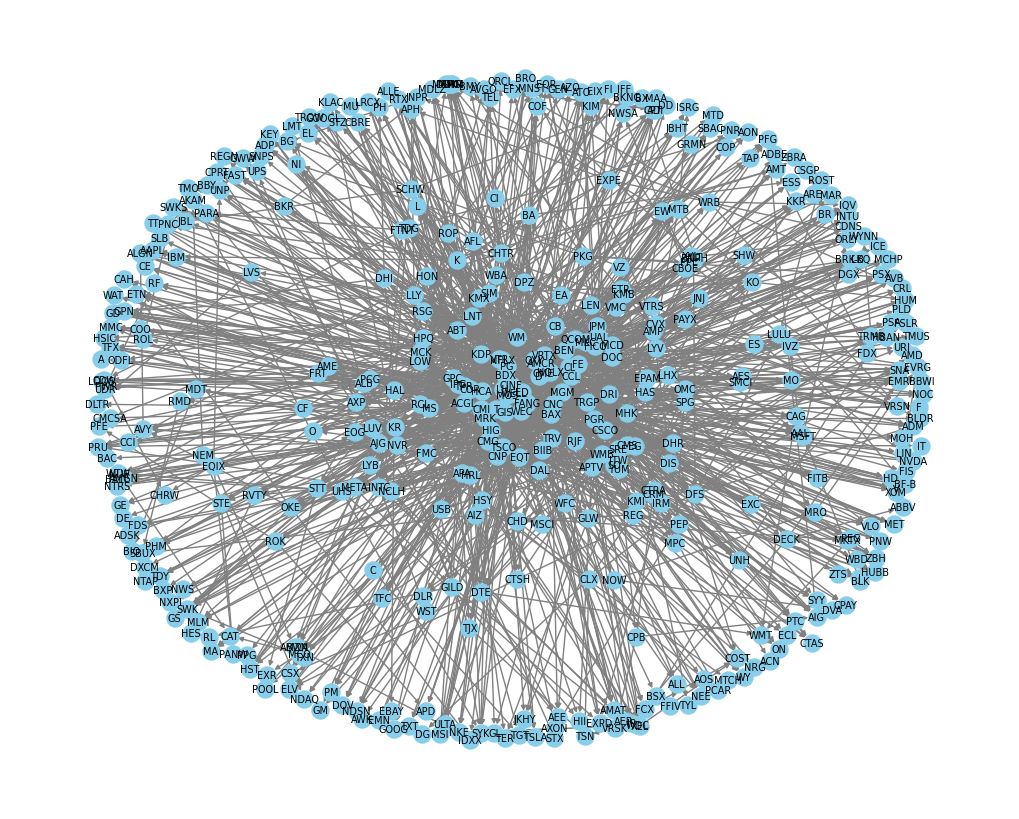

In [9]:
import matplotlib.pyplot as plt
pos = nx.spring_layout(G_major, seed=42, k=0.5, iterations=100)
plt.figure(figsize=(10, 8))

# Draw nodes, edges, and labels
nx.draw(G_major, pos, with_labels=True, node_size=150, node_color='skyblue', font_size=7, font_color='black', edge_color='gray', arrows=True, arrowsize=7)

# Optionally, draw edge labels to show weights
# edge_labels = nx.get_edge_attributes(G_major, 'weight')
# nx.draw_networkx_edge_labels(G_major, pos, edge_labels=edge_labels)

# Display the plot
plt.show()

In [14]:
in_degrees = dict(G_major.in_degree())
stocks_with_most_causes = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 nodes with the most causes:")
for node, degree in stocks_with_most_causes:
    causes = list(G_major.predecessors(node))
    print(f"Node {node}: {degree} causes {causes}")

Top 10 nodes with the most causes:
Node LKQ: 9 causes ['TRGP', 'CME', 'LNT', 'WEC', 'TPR', 'DRI', 'WM', 'CNP', 'LH']
Node GPC: 9 causes ['TRGP', 'MHK', 'CME', 'WEC', 'AJG', 'TPR', 'VTR', 'IPG', 'HCA']
Node RTX: 9 causes ['CMS', 'BDX', 'DPZ', 'WEC', 'TPR', 'DRI', 'VTR', 'IPG', 'WM']
Node AFL: 8 causes ['YUM', 'TRGP', 'BDX', 'EA', 'WEC', 'VTR', 'IPG', 'KDP']
Node AIG: 8 causes ['CMS', 'TRGP', 'BDX', 'MO', 'DRI', 'CPB', 'KDP', 'LH']
Node DFS: 8 causes ['TRGP', 'LULU', 'COR', 'VTR', 'HLT', 'CL', 'EQT', 'CNC']
Node SWK: 8 causes ['WEC', 'OKE', 'TSCO', 'ACGL', 'AJG', 'EQT', 'IPG', 'HCA']
Node VTR: 8 causes ['CHD', 'DAL', 'RJF', 'COR', 'DRI', 'LYB', 'APA', 'EOG']
Node BA: 8 causes ['PG', 'ED', 'WEC', 'TSCO', 'DRI', 'VTR', 'LLY', 'KDP']
Node CMS: 7 causes ['GIS', 'LOW', 'DFS', 'AMCR', 'WMB', 'PKG', 'APA']


In [15]:
out_degrees = dict(G_major.out_degree())
stocks_with_most_effects = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 nodes with the most effects:")
for node, degree in stocks_with_most_effects:
    effects = list(G_major.successors(node))
    print(f"Node {node}: {degree} effects {effects}")

Top 10 nodes with the most effects:
Node WEC: 92 effects ['ELV', 'CSCO', 'YUM', 'EMN', 'HUM', 'AFL', 'ABT', 'ODFL', 'NKE', 'LKQ', 'MSCI', 'V', 'HSIC', 'SCHW', 'F', 'AME', 'ULTA', 'HAL', 'CPAY', 'JPM', 'CTAS', 'TXT', 'CME', 'BRK-B', 'AMP', 'SPGI', 'ICE', 'AXP', 'PWR', 'ZBH', 'O', 'NWSA', 'PSX', 'UNH', 'KMI', 'KMX', 'MMC', 'BBWI', 'DOV', 'DAL', 'PH', 'LOW', 'ISRG', 'OXY', 'EMR', 'PRU', 'TFX', 'SNA', 'ALLE', 'CVX', 'OKE', 'ITW', 'IQV', 'COF', 'RJF', 'REG', 'ETN', 'GPC', 'NCLH', 'AAL', 'SWK', 'NTRS', 'IP', 'TPR', 'PTC', 'COP', 'NWS', 'FCX', 'GE', 'SRE', 'WY', 'SLB', 'GD', 'BBY', 'INTU', 'TDY', 'PNR', 'RTX', 'USB', 'BSX', 'GPN', 'BA', 'SYK', 'MET', 'CNP', 'APA', 'XOM', 'MTB', 'AON', 'SYY', 'FICO', 'MA']
Node CME: 79 effects ['SWKS', 'PG', 'CCI', 'NXPI', 'EXC', 'ABT', 'KMB', 'AMT', 'LKQ', 'NDSN', 'GLW', 'HUBB', 'CPAY', 'EL', 'BRK-B', 'AMP', 'SPGI', 'DTE', 'SBAC', 'ZBH', 'O', 'L', 'IFF', 'AMAT', 'UNH', 'IVZ', 'ECL', 'NOW', 'AVY', 'NI', 'BEN', 'ADSK', 'MDLZ', 'BF-B', 'ARE', 'HON', 'DPZ', 'WTW'